<div style="font-weight: bold; color:#00a55b" align="center">
    <div style="font-size: xx-large"></div>Aplicaciones de Análisis - Máster en Big Data y Data Science<br> <br>
    <div style="font-size: x-large; color:#A5644E">Análisis de Series Temporales: Energía Solar</div><br>
    <div style="font-size: large">Ángela Fernández Pascual - Universidad Autónoma de Madrid</div><br></div><hr>
</div>

A continuación se van a resumir los pasos a realizar para analizar y predecir una serie temporal, así como los paquetes y funciones necesarios para su ejecución en Python. 

**Configuración**

In [1]:
%%html
<style>
    .qst {background-color: #BBFFBB; padding:10px; border-radius: 5px; border: solid 2px #003300;}
    .qst:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #a5644e;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

Los paquetes de Python necesarios para trabajar con series temporales son:

* **numpy**
* **pandas**
* **matplotlib**
* **statsmodels**
* **sklearn**

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
matplotlib.rc('figure', figsize=(15, 5))

from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.stattools import adfuller, kpss

from os.path import isfile

import warnings
warnings.filterwarnings("ignore")

# Cargar los datos como serie temporal

Datos de ejemplo: **solar.csv**.

Este fichero contiene datos de producción de energía solar en unas coordenadas de Córdoba entre los años 2014 y 2016 (datos obtenidos de [NSRBD](https://ec.europa.eu/jrc/en/PVGIS/downloads/NSRDB)).

Para cargar los datos vamos a utilizar el paquete **pandas** y leeremos los datos desde un .csv, cargándolos como un tipo de dato serie temporal (tipo **Series**).
Para ello usamos la función **read_csv(FILE.csv)**, indicando como argumentos:
* **header**: fila donde está la cabecera de los datos.
* **parse_dates**: lista con las columnas donde está la información de las fechas con las que montar un tipo de dato datetime.
* **index_col**: columna con la que montar el índice de la serie.
* **use_cols**: de las diferentes columnas, cuáles tienen la información que queremos cargar en la serie.
* **squeeze**: si lo ponemos a True y cargamos solo las fechas + una columna de datos, lo guarda como tipo de dato Series.
* **dtype**: si lo ponemos a np.float64 le forzamos a guardar números reales.
* **dayfirst**: si lo activamos, indicamos que nuestras fechas tienen formato DD/MM (si no, por defecto asume que están en formato MM/DD).
* **sep**: para indicar el separador.

In [2]:
solar = pd.read_csv('solar.csv',
                    header=0, parse_dates=[0], index_col=[0], 
                    usecols=[0, 1], dayfirst=True, squeeze=True)

Para comprobar que hemos cargado bien los datos:
* Pintamos las primeras filas con el comando **head()**.
* Pintamos las últimas filas con el comando **tail()**.

In [4]:
num=10
print("PRIMEROS",num,"DATOS:"); print(solar.head(num))
print("ÚLTIMOS",num,"DATOS:"); print(solar.tail(num))

PRIMEROS 10 DATOS:
time
2014-01-01 00:00:00     0.00
2014-01-01 01:00:00     0.00
2014-01-01 02:00:00     0.00
2014-01-01 03:00:00     0.00
2014-01-01 04:00:00     0.00
2014-01-01 05:00:00     0.00
2014-01-01 06:00:00     0.00
2014-01-01 07:00:00     0.00
2014-01-01 08:00:00    20.54
2014-01-01 09:00:00    66.48
Name: P, dtype: float64
ÚLTIMOS 10 DATOS:
time
2016-12-31 14:00:00    105.84
2016-12-31 15:00:00    108.13
2016-12-31 16:00:00     46.05
2016-12-31 17:00:00      0.00
2016-12-31 18:00:00      0.00
2016-12-31 19:00:00      0.00
2016-12-31 20:00:00      0.00
2016-12-31 21:00:00      0.00
2016-12-31 22:00:00      0.00
2016-12-31 23:00:00      0.00
Name: P, dtype: float64


Ventajas del tipo de datos **Series** y tener las fechas como índices:
* Podemos cargar todos los datos de un año indicando: **series['2016']**
* Si tuviesemos datos diarios u horarios, podríamos sacar todos los datos relativos a un mes indicando: **series['2019-12']**
* Podemos seleccionar un rango de los datos por fechas: **series['2020':'2021']** o **series['2017-06':'2017-08']**
* Seguimos pudiendo utilizar los indices normales: **series[1:15]**, pero cuidado, perdemos el índice temporal.

<div class="qst">

* Muestra los datos de energía solar para los siguientes rangos de fechas:
    * Año 2016
    * Enero de 2014
    * Años 2015 y 2016
    * De enero de 2014 a junio de 2014 (ambos meses incluidos)
    * Lo 10 primeros elementos de la Serie.

</div>

# Análisis de los datos

## Visualización

Una de las primeras cosas que debemos hacer es visualizar bien los datos para entender el problema al que nos enfrentamos e intentar indagar sobre posibles tendencias o periodos estacionales.

Primero deberíamos visualizar la serie completa. Después podemos hacer zoom para detectar otros detalles.

<AxesSubplot:xlabel='time'>

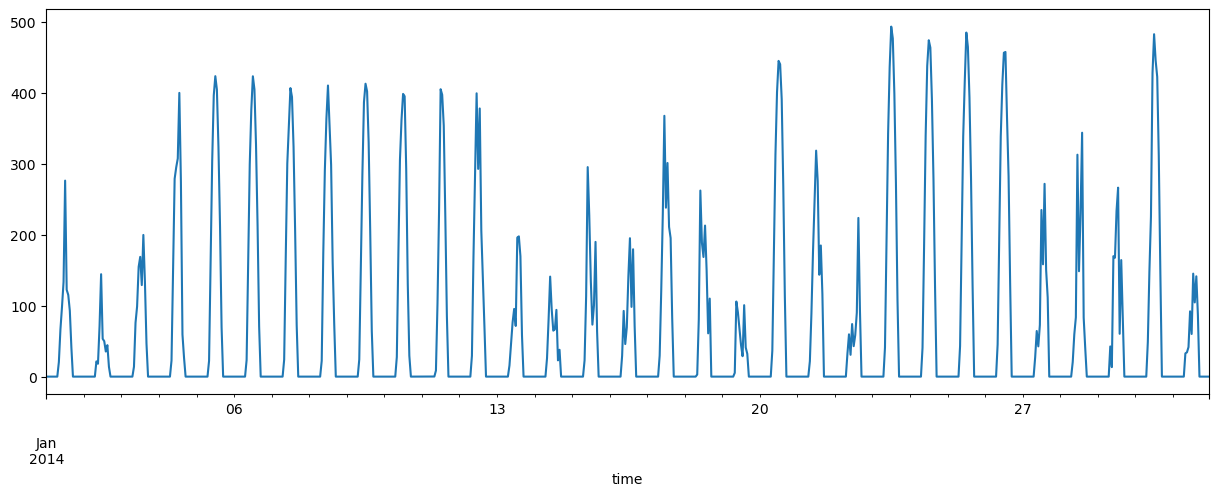

In [5]:
plt.figure();solar['2014-01'].plot()

<AxesSubplot:xlabel='time'>

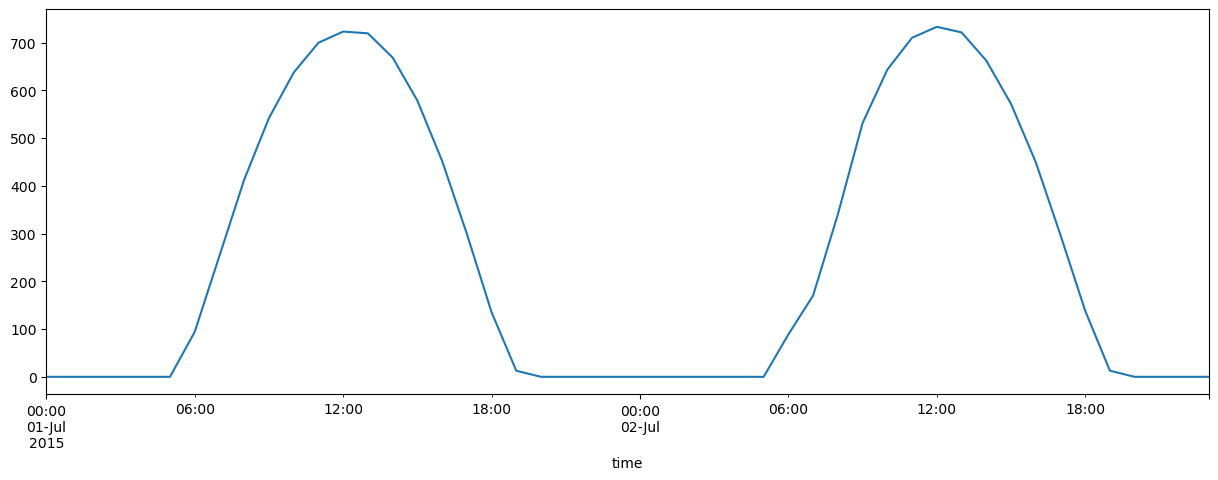

In [6]:
plt.figure();solar['2015-07-01':'2015-07-02'].plot()

<div class="qst">

* ¿Qué peculiaridades de estos datos se aprecian en estas gráficas?

</div>

## Análisis estadístico y preproceso de los datos

Además del análisis visual, es fundamental realizar un buen análsis estadśitico. Para tener una primera idea más concreta de los datos a los que nos enfrentamos, podemos sacar unos primeros estadísticos sobre los mismos usando la función **describe()**.

In [7]:
solar.describe()

count    26304.000000
mean       159.245979
std        227.678783
min          0.000000
25%          0.000000
50%          0.000000
75%        297.302500
max        798.140000
Name: P, dtype: float64

<div class="qst">

* ¿Qué nos dice esta función sobre nuestros datos?

</div>

Otra cuestión importante es si tenemos huecos en los datos, pues en una serie temporal, donde esperamos tener intervalos de tiempo constantes entre un dato y el siguiente, hay que rellenar los huecos. Para comprobar si hay huecos podemos usar la función **isna()** que Series tiene implementada. Para ver si hay algún hueco combinamos isna() con la función **any()**. Si devuelven **True** debemos rellenar huecos.

In [8]:
solar.isna().any()

False

Encontrar la mejor solución para rellenar estos huecos dependerá del problema a resolver, del número de huecos, cómo de agrupados están... Pero una buena solución de compromiso es hacer una interpolación lineal en lo datos. Para ello podemos usar la función **series.interpolate()** de pandas. A partir de este momento trabajaremos siempre con la serie interpolada.

En este caso en concreto no tenemos huecos, por lo que vamos a seguir trabajando sobre la serie original, pero en otros casos ¡puede ser muy importante!

## Análisis de tendencia y estacionalidad

### Seasonal Decompose

Para obtener una primera idea de si nuestros datos presentan alguna tendencia o estacionalidad podemos usar la función `seasonal_decompose()`. Cuidado con esta función, porque si no la utilizamos adecuadamente, puede darnos una falsa idea de nuestros datos. Para usarla bien, primero debemos saber si nuestros datos se descompondrán mejor con un modelo aditivo o multiplicativo (los datos reales no siempre siguen uno de estos modelos), y es crucial el parámetro `period` en caso de estacionalidad. El parámetro `period` ( o `freq` en versiones anteriores) indica el tamaño de cada periodo estacional.

En nuestro ejemplo debemos descartar un modelo multiplicativo por tener datos a "0".

<Figure size 1500x500 with 0 Axes>

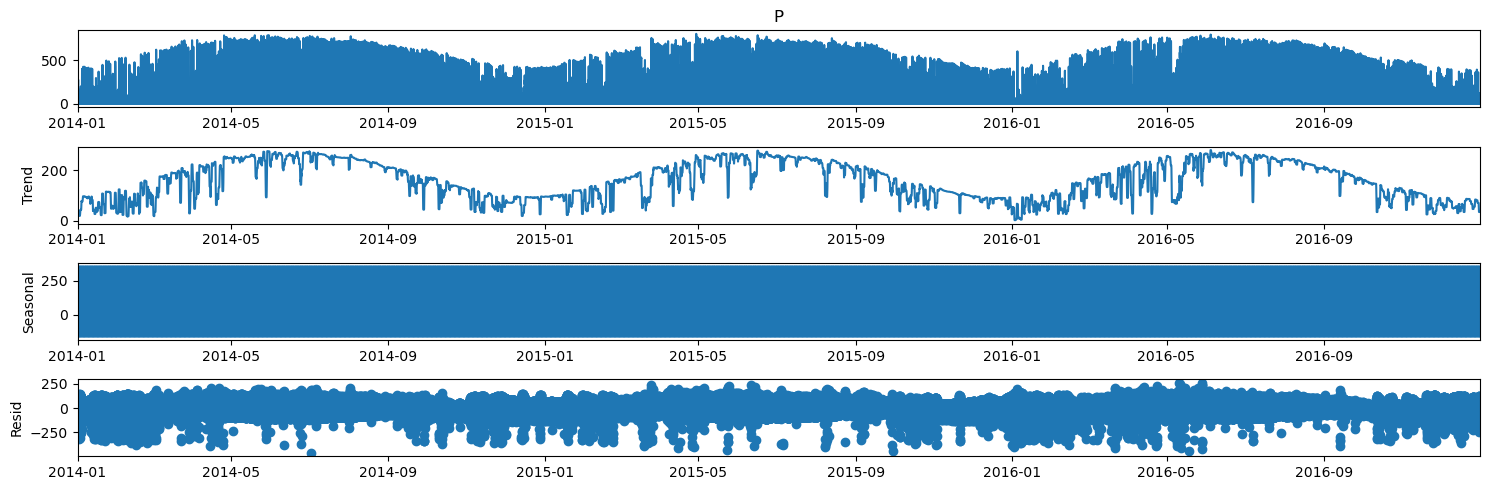

In [15]:
solar_copy = solar['2014':'2016'].copy()
result=tsa.seasonal_decompose(solar_copy, model='additive', period=24)
plt.figure();result.plot();

<div class="qst">

* Con este método intenta buscar en los datos:
    * Una estacionalidad diaria.
    * Un estacionalidad mensual.
    * Una estacionalidad anual.
    
* ¿Qué se aprecia con estos valores de `period`?

</div>

### Test ADF

Recordemos las hipótesis del test ADF:
* *Hipótesis nula*: La ST es no estacionaria.
* *Hipótesis alternativa*: La serie es estacionaria.

In [10]:
dftest = adfuller(solar)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                         'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Test Statistic                -6.684451e+00
p-value                        4.260858e-09
#Lags Used                     4.900000e+01
Number of Observations Used    2.625400e+04
Critical Value (1%)           -3.430599e+00
Critical Value (5%)           -2.861650e+00
Critical Value (10%)          -2.566829e+00
dtype: float64


### Test KPSS

Recordemos las hipótesis del test KPSS:
* *Hipótesis nula*: La ST es estacionaria, pero con tendencia.
* *Hipótesis alternativa*: La serie es no estacionaria.

In [16]:
kpsstest = kpss(solar)
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic            2.008968
p-value                   0.010000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<div class="qst">

* Si fijamos un nivel de significancia de $0,05$, ¿qué podemos concluir a la vista de los resultados obtenidos? 
    
</div>

## Conversión en ST Estacionarias

`seasonal_decompose()` y los tests ADF y KPSS **NO** quitan tendencias ni estacionalidad, solo nos ayudan a analizar la serie. Para quitar estos fenómenos y hacer nuestra serie estacionaria debemos sustituir nuestra serie por una serie de diferencias, para lo que podemos usar la función `diff()`.

`diff()` permite utilizar como argumento el número de retrasos (la frecuencia en caso de periodos estacionales).

Observad que al realizar la serie de diferencias perdemos tantos valores como retrasos usemos.

time
2014-01-01 00:00:00    NaN
2014-01-01 01:00:00    NaN
2014-01-01 02:00:00    NaN
2014-01-01 03:00:00    NaN
2014-01-01 04:00:00    NaN
2014-01-01 05:00:00    NaN
2014-01-01 06:00:00    NaN
2014-01-01 07:00:00    NaN
2014-01-01 08:00:00    NaN
2014-01-01 09:00:00    NaN
2014-01-01 10:00:00    NaN
2014-01-01 11:00:00    NaN
2014-01-01 12:00:00    NaN
2014-01-01 13:00:00    NaN
2014-01-01 14:00:00    NaN
2014-01-01 15:00:00    NaN
2014-01-01 16:00:00    NaN
2014-01-01 17:00:00    NaN
2014-01-01 18:00:00    NaN
2014-01-01 19:00:00    NaN
2014-01-01 20:00:00    NaN
2014-01-01 21:00:00    NaN
2014-01-01 22:00:00    NaN
2014-01-01 23:00:00    NaN
2014-01-02 00:00:00    0.0
2014-01-02 01:00:00    0.0
2014-01-02 02:00:00    0.0
Name: P, dtype: float64


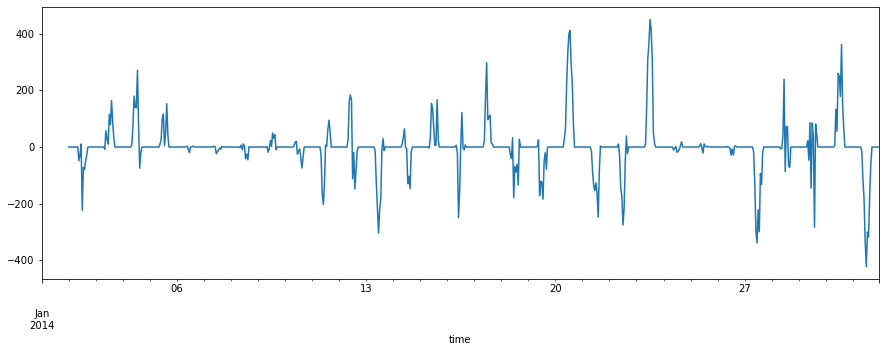

In [17]:
#Si queremos quitar una estacionalidad, el lag tiene que ser el periodo estacional
lag = 24 #24 indica un periodo diario
series_diff_Est=solar.diff(lag)
print(series_diff_Est.head(27))
plt.figure();series_diff_Est['2014-01'].plot()

#Si queremos quitar una tendencia, el lag tiene que ser 1
#Para quitar tendencias polinómicas diferenciamos tantas veces como el orden del polinomio 
lagTrend = 1
series_sta=solar.diff(lagTrend)
series_sta2=series_sta.diff(lagTrend)
# ...

#Realmente este ejemplo no tiene tendencia, pero sí estacionalidad, por lo que nos quedamos con la serie sin los NaN
series_stacionary=series_diff_Est[lag:-1]

Podemos comprobar si hemos conseguido una serie estacionaria aplicando de nuevo los tests.

In [18]:
dftest = adfuller(series_stacionary)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                         '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                   -30.397422
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    26229.000000
Critical Value (1%)               -3.430599
Critical Value (5%)               -2.861650
Critical Value (10%)              -2.566829
dtype: float64


In [19]:
kpsstest = kpss(series_stacionary)
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic            0.021552
p-value                   0.100000
Lags Used                55.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<div class="qst">

* Si fijamos de nuevo un nivel de significancia de $0,05$, ¿qué podemos concluir a la vista de los resultados obtenidos con la serie de diferencias? 
    
</div>

Puesto que esto es un punto crítico de nuestro trabajo con series temporales, es posible que nos interese guardar esta nueva serie para futuros trabajos. Podemos hacerlo en formato .csv con la función `to_csv(FILE.csv)` y así podrías recuperarla en cualquier momento, cargándola como se indicaba al principio.

In [20]:
series_stacionary.to_csv('solar_estacionaria.csv', header=True)

## Análisis de ACF y PACF

El último elemento de análisis son los correlogramas y correlogramas parciales. Para ello podemos usar las funciones `plot_acf()` y `plot_pacf()`. 

<Figure size 1080x360 with 0 Axes>

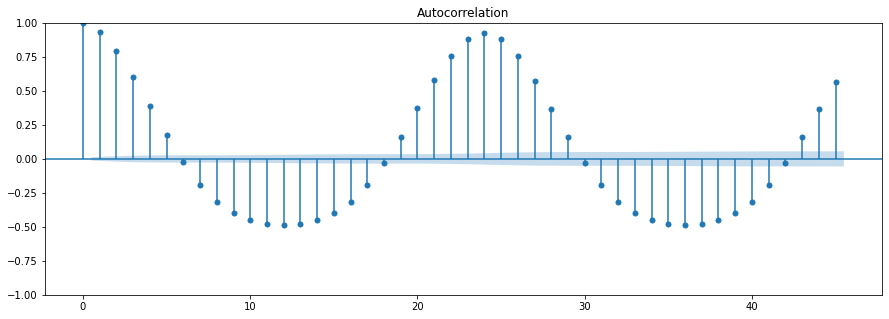

<Figure size 1080x360 with 0 Axes>

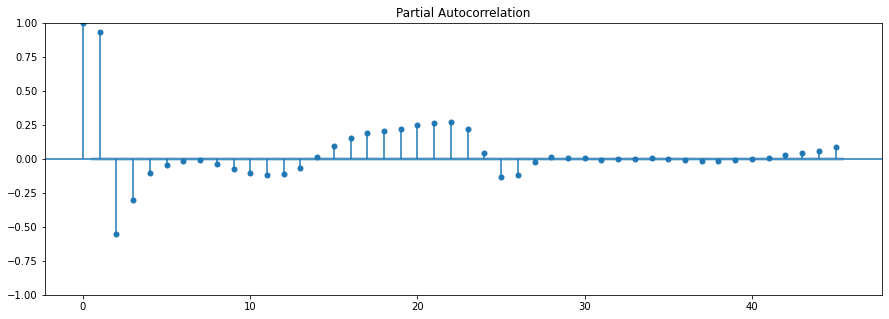

In [21]:
plt.figure(); tsaplots.plot_acf(solar); plt.show()
plt.figure(); tsaplots.plot_pacf(solar); plt.show()

Cuando tenemos series muy largas y estos diagramas nos muestran demasiados retrasos podemos indicarle por argumento cuántos retrasos queremos visualizar (al final los primeros siempre son los más interesantes).

<Figure size 1080x360 with 0 Axes>

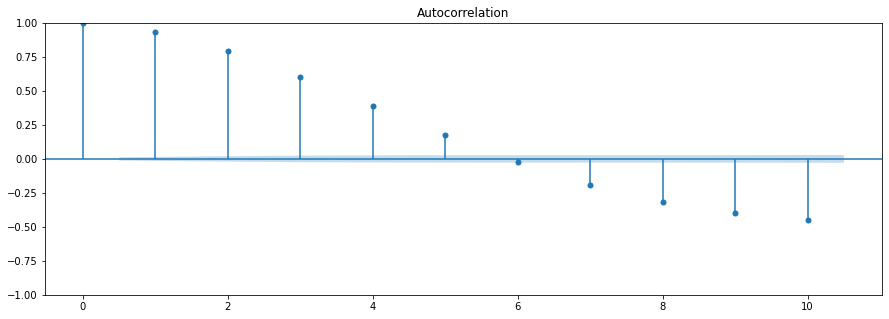

In [22]:
plt.figure(); tsaplots.plot_acf(solar, lags=10); plt.show()

Este análisis suele realizarse sobre los datos estacionarios, por lo que vamos a repetirlo sobre la serie de diferencias.

<Figure size 1080x360 with 0 Axes>

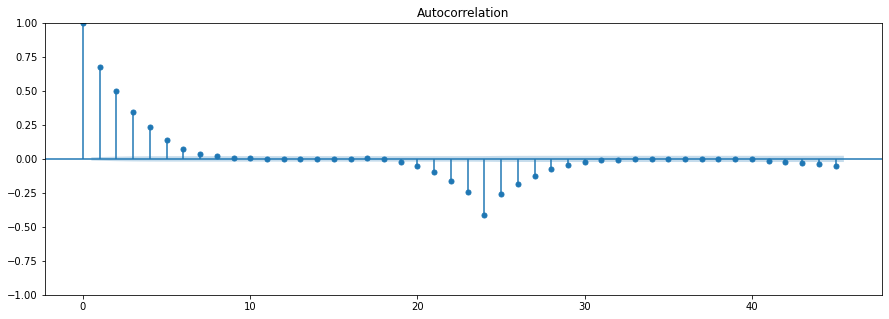

<Figure size 1080x360 with 0 Axes>

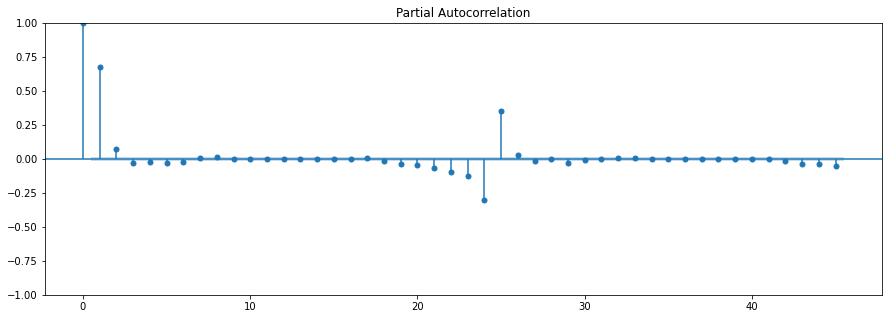

In [23]:
plt.figure(); tsaplots.plot_acf(series_stacionary); plt.show()
plt.figure(); tsaplots.plot_pacf(series_stacionary); plt.show()

<div class="qst">

* ¿Qué se aprecia en estas gráficas? ¿Qué diferencia hay al aplicarla sobre la gráfica estacionaria y la no estacionaria?
    
</div>